## model try


### Load libraries

In [1]:
from cv2 import cv2
import os
import json
import time

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from src.data.my_rpg_dataset import XRayDataSet_windows
from src.data.my_rpg_dataset import collate_fn
from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch

In [5]:
print(os.getcwd())  

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


In [2]:
def get_model_instance_segmentation(num_classes):
      
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [5]:
model = get_model_instance_segmentation(3)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Real try of the Model

In [6]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [3]:
#keep only predictions with score higher than the threshold
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [5]:
#load train data
train_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/pickle_data'))
training_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4,collate_fn=collate_fn)

#load validation data
validation_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/validation_pickles'))
validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False, num_workers=4,collate_fn=collate_fn)

#load test data
test_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles'))
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4,collate_fn=collate_fn)

## Model Testing

In [14]:
#load test data
test_dataset = XRayDataSet_windows(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)

In [5]:
#load the model state

model = get_model_instance_segmentation(3)
model.load_state_dict(torch.load(f'../CNN_Model.pt'))


<All keys matched successfully>

In [6]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img,cmap='gray')
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].detach().numpy()

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [7]:
import numpy as np
from torchvision.ops import box_iou

score_threshold = 0.7
iou_threshold = 0.5

In [8]:
print('----------------------Model evaluation started--------------------------')

device = next(model.parameters()).device
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_dataloader):
    
        images =list(img for img in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
            
        outputs = model(images)

        for i, output in enumerate(outputs):
            boxes = output['boxes'].detach().cpu()
            scores = output['scores'].detach().cpu().numpy()
            labels = output['labels'].detach().cpu().numpy()
            target_boxes = targets[i]['boxes'].cpu()
            target_labels = targets[i]['labels'].cpu().numpy()
            total += target_labels.size
            for box, score, label in zip(boxes, scores, labels):
                if label in target_labels:
                    index = np.where(target_labels == label)[0][0]
                    if score > score_threshold and box_iou(box.unsqueeze(0), target_boxes[index].unsqueeze(0)) > iou_threshold:
                        correct += 1

accuracy = 100 * correct / total

print('----------------------train ended--------------------------')
print('The total model accuracy in the test set was: ', accuracy)
        

----------------------Model evaluation started--------------------------


100%|██████████| 1000/1000 [1:43:20<00:00,  6.20s/it]

----------------------train ended--------------------------
The total model accuracy in the test set was:  76.75222112537018


In [15]:
iteration =  iter(test_dataloader)

In [20]:
model.eval()
images , targets = next(iteration)
imgs = list(img for img in images)
predictions = model(imgs)

In [21]:
predictions

[{'boxes': tensor([[312.3975, 849.5986, 338.4219, 879.4339]], grad_fn=<StackBackward0>),
  'labels': tensor([2]),
  'scores': tensor([0.9996], grad_fn=<IndexBackward0>)}]

Target :  tensor([2])


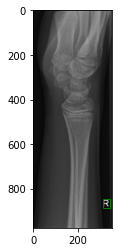

In [22]:
print("Target : ",targets[0]['labels'])
plot_image_from_output(images[0], targets[0])

Prediction :  tensor([2])


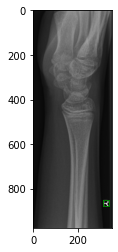

In [23]:
print("Prediction : ", predictions[0]['labels'])
plot_image_from_output(images[0],predictions[0])

In [41]:
import torch
import pickle
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


# Load the pickled object
filename = "../losses.pickle"
with open(filename, 'rb') as f:
    data = CPU_Unpickler(f).load()





In [42]:
data = [t.cpu().detach().numpy() for t in data[0]]


In [36]:
len(data)

200

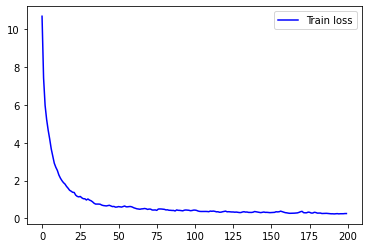

In [43]:
epochs = 200

#plot validation loss over training
plt.plot(list(range(0,epochs)), data, color='blue', label='Train loss')
#plt.plot(list(range(0,epochs)), val_loss, color = 'red', label='Validation loss')
plt.legend()